In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.models import load_model
import tensorflow as tf

# # Path to your dataset
# dataset_path = 'dataset_blood_group'

# # Function to split dataset into train and test
# def split_dataset(dataset_path, output_train, output_test, test_size=0.2):
#     if not os.path.exists(output_train):
#         os.makedirs(output_train)
#     if not os.path.exists(output_test):
#         os.makedirs(output_test)
        
#     for category in os.listdir(dataset_path):
#         category_path = os.path.join(dataset_path, category)
#         images = os.listdir(category_path)
#         train_images, test_images = train_test_split(images, test_size=test_size)
        
#         os.makedirs(os.path.join(output_train, category), exist_ok=True)
#         os.makedirs(os.path.join(output_test, category), exist_ok=True)
        
#         for image in train_images:
#             shutil.copy(os.path.join(category_path, image), os.path.join(output_train, category, image))
        
#         for image in test_images:
#             shutil.copy(os.path.join(category_path, image), os.path.join(output_test, category, image))

# # Split the data into train and test folders
# train_dir = 'train_data'
# test_dir = 'test_data'
# split_dataset(dataset_path, train_dir, test_dir)

## **MobileNet Model**

In [17]:
from tensorflow.keras.applications import DenseNet121
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a DenseNet model to extract features
densenet_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')

# Image Data Generator to load images
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False)
test_data = datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False)

# Extract features using DenseNet
train_features = densenet_model.predict(train_data)
test_features = densenet_model.predict(test_data)

# Save the extracted features using joblib
joblib.dump(train_features, 'train_features.joblib')
joblib.dump(test_features, 'test_features.joblib')
joblib.dump(train_data.classes, 'train_labels.joblib')
joblib.dump(test_data.classes, 'test_labels.joblib')


Found 4996 images belonging to 9 classes.
Found 1404 images belonging to 9 classes.
44/44 [==============================] - 34s 764ms/step


['test_labels.joblib']

In [18]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

# Load extracted features
train_features = joblib.load('train_features.joblib')
test_features = joblib.load('test_features.joblib')
train_labels = joblib.load('train_labels.joblib')
test_labels = joblib.load('test_labels.joblib')

# Normalize the features
train_features /= np.max(train_features)
test_features /= np.max(test_features)

# Build MobileNet-based classifier
mobilenet_model = Sequential([
    Dense(256, activation='relu', input_shape=(train_features.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # 8 categories
])

mobilenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_mobilenet = mobilenet_model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(test_features, test_labels),
    callbacks=[early_stopping]
)

# Save the model
mobilenet_model.save('mobilenet_classifier.h5')

Epoch 1/20
157/157 [==============================] - 2s 8ms/step - loss: 1.9074 - accuracy: 0.2726 - val_loss: 1.3394 - val_accuracy: 0.4808
Epoch 2/20
157/157 [==============================] - 1s 6ms/step - loss: 1.4804 - accuracy: 0.4075 - val_loss: 1.0943 - val_accuracy: 0.5570
Epoch 3/20
157/157 [==============================] - 1s 6ms/step - loss: 1.3080 - accuracy: 0.4780 - val_loss: 0.9992 - val_accuracy: 0.5919
Epoch 4/20
157/157 [==============================] - 1s 6ms/step - loss: 1.1920 - accuracy: 0.5184 - val_loss: 0.8729 - val_accuracy: 0.6553
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 1.0920 - accuracy: 0.5604 - val_loss: 0.8031 - val_accuracy: 0.6745
Epoch 6/20
157/157 [==============================] - 1s 6ms/step - loss: 1.0141 - accuracy: 0.6107 - val_loss: 0.7729 - val_accuracy: 0.6944
Epoch 7/20
157/157 [==============================] - 1s 6ms/step - loss: 0.9567 - accuracy: 0.6313 - val_loss: 0.7153 - val_accuracy: 0.7137
Epoch 

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


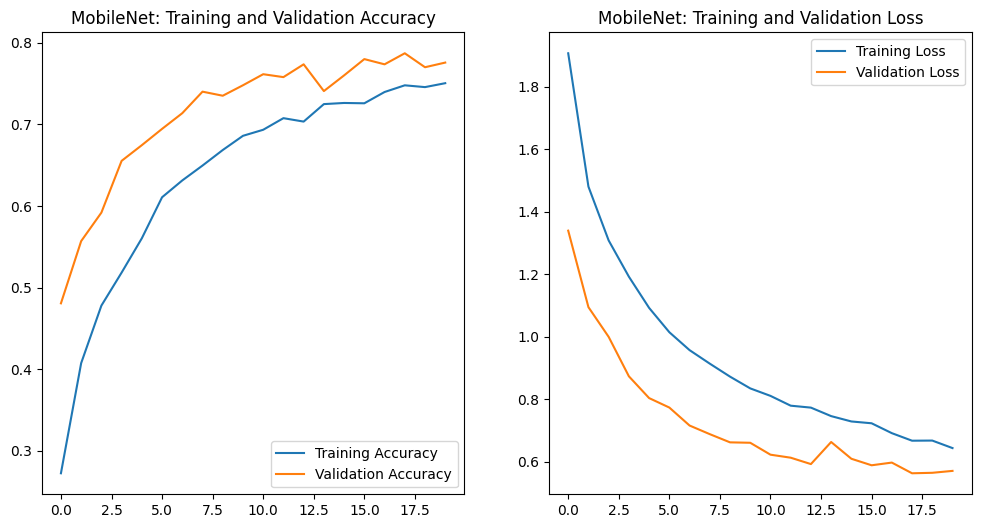

In [19]:
# Function to plot training history
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name}: Training and Validation Loss')

    plt.show()
# Plotting for MobileNet trained on DenseNet features
plot_training_history(history_mobilenet, 'MobileNet')


In [21]:
# Evaluate the model
Y_pred_mobilenet = mobilenet_model.predict(test_features)
y_pred_mobilenet = np.argmax(Y_pred_mobilenet, axis=1)

# Classification report
print('MobileNet Classification Report')
print(classification_report(test_labels, y_pred_mobilenet, target_names=train_data.class_indices.keys()))

44/44 [==============================] - 0s 3ms/step
MobileNet Classification Report
              precision    recall  f1-score   support

          A+       0.92      0.72      0.81       113
          A-       0.66      0.83      0.74       202
         AB+       0.72      0.80      0.76       142
         AB-       0.68      0.75      0.71       153
          B+       0.76      0.78      0.77       131
          B-       0.89      0.74      0.81       149
          O+       0.76      0.60      0.67       171
          O-       0.68      0.70      0.69       143
      unknow       1.00      1.00      1.00       200

    accuracy                           0.78      1404
   macro avg       0.79      0.77      0.77      1404
weighted avg       0.79      0.78      0.78      1404



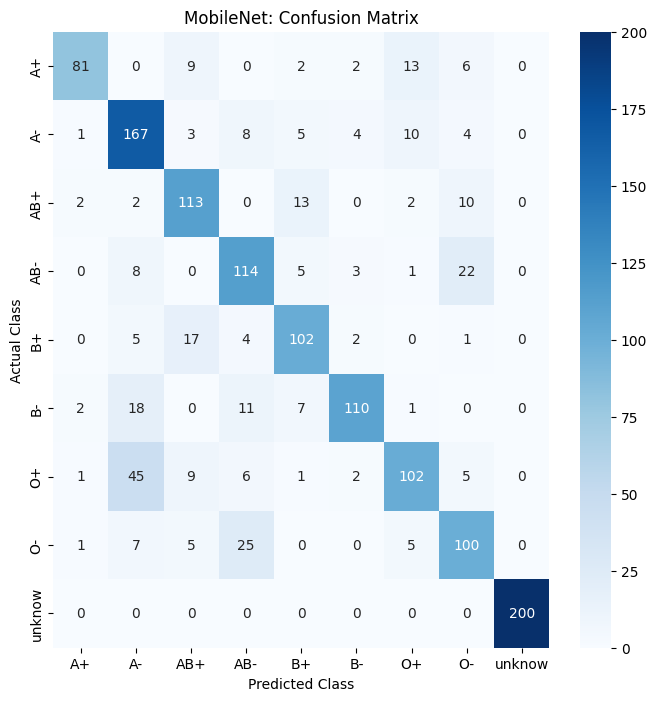

In [22]:
# Confusion matrix
cm_mobilenet = confusion_matrix(test_labels, y_pred_mobilenet)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys())
plt.title('MobileNet: Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


## **ResNet+RNN Model**

In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Image Data Generator to load images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=True)
test_data = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False)

# ResNet + LSTM Model
def create_resnet_lstm_model(input_shape, num_classes):
    # Load ResNet50 with pre-trained ImageNet weights
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    resnet_base.trainable = False  # Freeze ResNet layers

    model = Sequential([
        resnet_base,  # Feature extraction using ResNet
        GlobalAveragePooling2D(),  # Pooling layer
        Flatten(),
        Dense(256, activation='relu'),  # Dense layer before LSTM
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)  # Image shape
num_classes = 9 
# Create the hybrid ResNet + LSTM model
resnet_lstm_model = create_resnet_lstm_model(input_shape, num_classes)

# Print model summary
resnet_lstm_model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the ResNet + LSTM model
history_resnet_lstm = resnet_lstm_model.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=[early_stopping]
)

# Save the trained model
resnet_lstm_model.save('resnet_rnn_hybrid_model.h5')

Found 4996 images belonging to 9 classes.
Found 1404 images belonging to 9 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


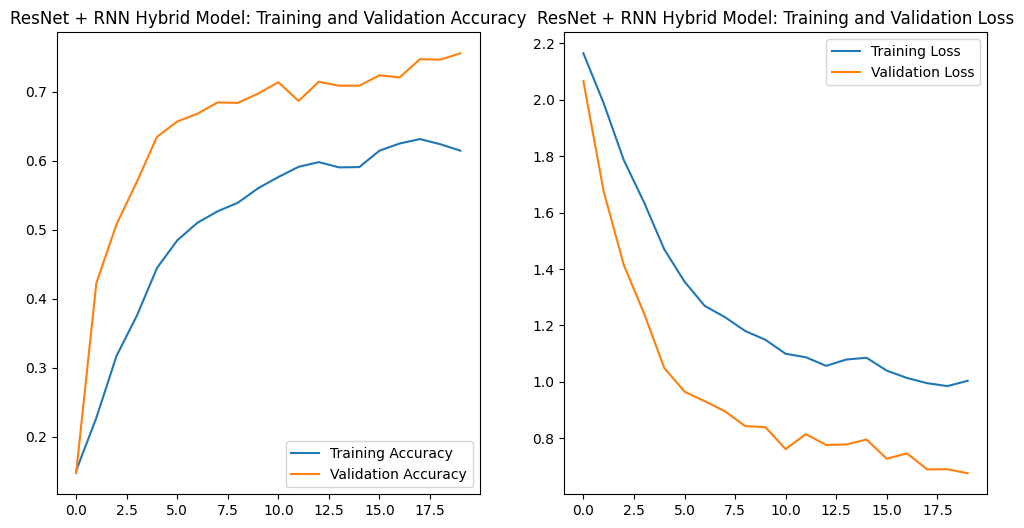

In [27]:
# Function to plot training history
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name}: Training and Validation Loss')

    plt.show()

# Plot training history for ResNet + LSTM hybrid model
plot_training_history(history_resnet_lstm, 'ResNet + RNN Hybrid Model')


In [30]:
# Evaluate the model
Y_pred_resnet_rnn = resnet_lstm_model.predict(test_data)
y_pred_resnet_rnn = np.argmax(Y_pred_resnet_rnn, axis=1)

# Classification report
print('ResNet + RNN Hybrid Model: Classification Report')
print(classification_report(test_data.classes, y_pred_resnet_rnn, target_names=test_data.class_indices.keys()))


44/44 [==============================] - 35s 798ms/step
ResNet + RNN Hybrid Model: Classification Report
              precision    recall  f1-score   support

          A+       0.69      0.77      0.72       113
          A-       0.69      0.62      0.65       202
         AB+       0.71      0.81      0.76       142
         AB-       0.70      0.72      0.71       153
          B+       0.77      0.80      0.78       131
          B-       0.78      0.84      0.81       149
          O+       0.71      0.57      0.63       171
          O-       0.69      0.67      0.68       143
      unknow       1.00      1.00      1.00       200

    accuracy                           0.76      1404
   macro avg       0.75      0.76      0.75      1404
weighted avg       0.75      0.76      0.75      1404



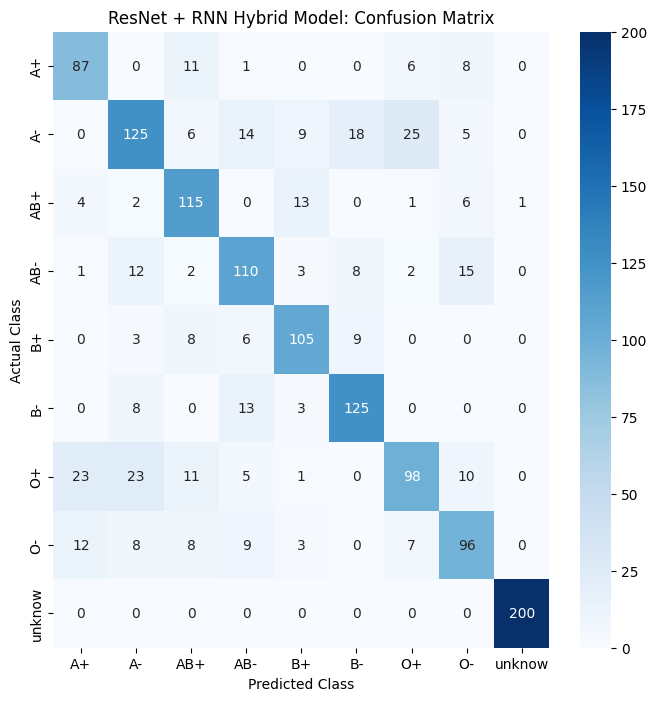

In [32]:
# Confusion matrix
cm_resnet_lstm = confusion_matrix(test_data.classes, y_pred_resnet_rnn)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_resnet_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('ResNet + RNN Hybrid Model: Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

## **Prediction Logic**

In [58]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
import numpy as np
import joblib

# Load the DenseNet feature extractor
densenet_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')

# Load the trained MobileNet model
mobilenet_model = load_model('mobilenet_classifier.h5')

# Load the class labels (ensure this matches the training class indices)
class_indices = train_data.class_indices  # Assuming `train_data` is from earlier training
class_labels = {v: k for k, v in class_indices.items()}  # Reverse the dictionary to get labels from indices

# Function to extract features using DenseNet and predict using MobileNet
def predict_with_mobilenet(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using DenseNet
    features = densenet_model.predict(img_array)  # Extract DenseNet features

    # Make prediction using the MobileNet model
    prediction = mobilenet_model.predict(features)  # Pass features to MobileNet

    # Get the predicted class index and corresponding label
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    print(f"Predicted class for {image_path}: {predicted_label}")
    return predicted_label

# Example usage
image_path = 'test_data/AB+/cluster_4_12.BMP'
predict_with_mobilenet(image_path)

1/1 [==============================] - 0s 79ms/step
Predicted class for test_data/AB+/cluster_4_12.BMP: AB+


'AB+'

In [47]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained ResNet + LSTM hybrid model
resnet_lstm_model = load_model('resnet_rnn_hybrid_model.h5')

# Load the class labels (ensure this matches the training class indices)
class_indices = train_data.class_indices  # Assuming `train_data` is from earlier training
class_labels = {v: k for k, v in class_indices.items()}  # Reverse the dictionary to get labels from indices

# Function to preprocess the image and predict using ResNet + LSTM
def predict_with_resnet_lstm(image_path):
    # Load the image and preprocess
    img = image.load_img(image_path, target_size=(128, 128))  # Resize the image
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction using ResNet + LSTM model
    prediction = resnet_lstm_model.predict(img_array)

    # Get the predicted class index and corresponding label
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    print(f"Predicted class for {image_path}: {predicted_label}")
    return predicted_label

# Example usage
image_path = 'test_data/AB+/cluster_4_12.BMP'
predict_with_resnet_lstm(image_path)


1/1 [==============================] - 1s 1s/step
Predicted class for test_data/AB+/cluster_4_12.BMP: AB+


'AB+'

## **Fully connected Neural Network** ##

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load features and labels from joblib files
X_train = joblib.load('train_features.joblib')  # Load training features
y_train = joblib.load('train_labels.joblib')     # Load training labels

# Print the original shape of the loaded features
print("Original X_train shape:", X_train.shape)

# One-hot encode labels if not already done
num_classes = 9  # Adjust based on your number of classes
y_train = to_categorical(y_train, num_classes)

# Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define a simple fully connected model for flattened input
def create_fully_connected_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))  # Flattened input
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Create and compile the model
input_shape = X_train.shape[1]  # This will be 1024
fc_model = create_fully_connected_model(input_shape, num_classes)
fc_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = fc_model.fit(X_train_split, y_train_split,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stopping])

# Save the model
fc_model.save('fc_model.h5')


Original X_train shape: (4996, 1024)
Epoch 1/50
125/125 [==============================] - 3s 14ms/step - loss: 1.9260 - accuracy: 0.3071 - val_loss: 1.4426 - val_accuracy: 0.4770
Epoch 2/50
125/125 [==============================] - 2s 13ms/step - loss: 1.4733 - accuracy: 0.4212 - val_loss: 1.2137 - val_accuracy: 0.5150
Epoch 3/50
125/125 [==============================] - 2s 13ms/step - loss: 1.3138 - accuracy: 0.4892 - val_loss: 1.1970 - val_accuracy: 0.5530
Epoch 4/50
125/125 [==============================] - 1s 12ms/step - loss: 1.2066 - accuracy: 0.5258 - val_loss: 1.0897 - val_accuracy: 0.5770
Epoch 5/50
125/125 [==============================] - 1s 12ms/step - loss: 1.1305 - accuracy: 0.5641 - val_loss: 0.9683 - val_accuracy: 0.6310
Epoch 6/50
125/125 [==============================] - 1s 12ms/step - loss: 1.0665 - accuracy: 0.5971 - val_loss: 0.9590 - val_accuracy: 0.6060
Epoch 7/50
125/125 [==============================] - 1s 12ms/step - loss: 1.0146 - accuracy: 0.6129 - va

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


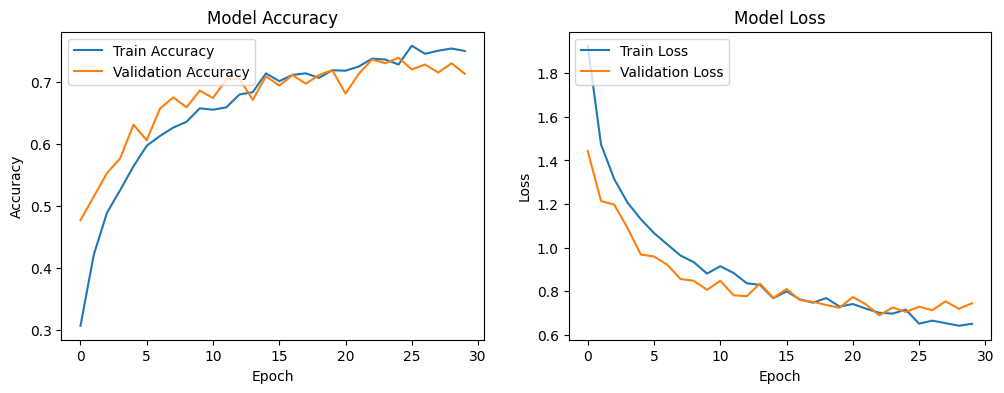

In [64]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [65]:
# Predictions on validation set
y_val_pred = fc_model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert y_val back to original classes
y_val_classes = np.argmax(y_val, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_val_classes, y_val_pred_classes))

32/32 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        98
           1       0.66      0.69      0.67       174
           2       0.72      0.83      0.77       117
           3       0.73      0.73      0.73       109
           4       0.68      0.76      0.71        98
           5       0.72      0.85      0.78       109
           6       0.80      0.55      0.65       143
           7       0.75      0.69      0.72       111
           8       0.98      1.00      0.99        41

    accuracy                           0.74      1000
   macro avg       0.76      0.77      0.76      1000
weighted avg       0.74      0.74      0.74      1000



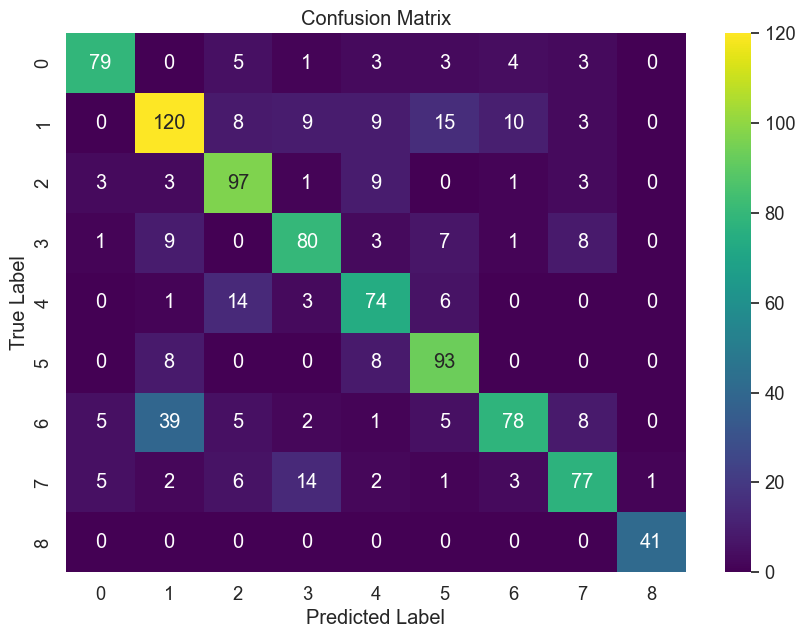

In [66]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val_classes, y_val_pred_classes)

# Plotting the confusion matrix with color
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)  # Increase font size for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **CNN Model** ##


Found 4996 images belonging to 9 classes.
Found 1404 images belonging to 9 classes.



Epoch 1/5


157/157 [==============================] - 56s 349ms/step - loss: 1.3686 - accuracy: 0.4992 - val_loss: 0.5986 - val_accuracy: 0.7821
Epoch 2/5
157/157 [==============================] - 24s 152ms/step - loss: 0.4467 - accuracy: 0.8365 - val_loss: 0.4659 - val_accuracy: 0.8170
Epoch 3/5
157/157 [==============================] - 26s 164ms/step - loss: 0.3022 - accuracy: 0.8893 - val_loss: 0.2803 - val_accuracy: 0.8896
Epoch 4/5
157/157 [==============================] - 22s 138ms/step - loss: 0.1944 - accuracy: 0.9317 - val_loss: 0.2480 - val_accuracy: 0.9081
Epoch 5/5
157/157 [==============================] - 21s 135ms/step - loss: 0.1119 - accuracy: 0.9698 - val_loss: 0.2825 - val_accuracy: 0.8925


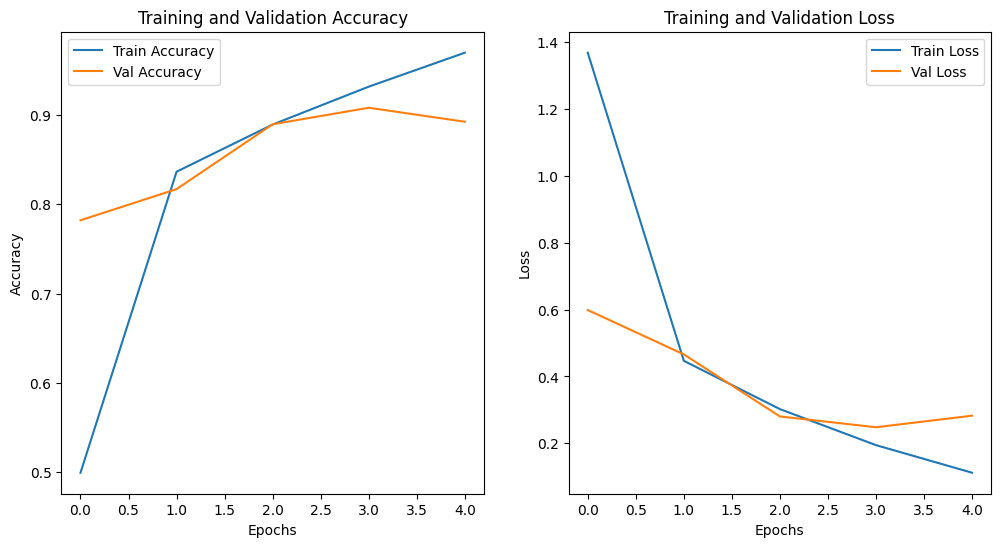

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths for train and test data
train_data_dir = 'train_data'
test_data_dir = 'test_data'

# ImageDataGenerator for data augmentation and rescaling
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load train and test data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),  # Resize the images to 128x128 
    batch_size=32,  
    class_mode='categorical'  # Since it’s a multi-class classification problem
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Define the CNN model 
def create_simple_cnn(input_shape=(128, 128, 3), num_classes=9):
    model = tf.keras.models.Sequential()

    # Convolutional Layer 1
    model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(tf.keras.layers.Flatten())

    # Dense Layer
    model.add(tf.keras.layers.Dense(64, activation='relu'))

    # Output Layer (Softmax for multi-class classification)
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create and compile the model
simple_cnn = create_simple_cnn(input_shape=(128, 128, 3), num_classes=9)

# Train the model
history = simple_cnn.fit(
    train_generator,
    epochs=5,  
    validation_data=test_generator
)

# Plot the training and validation accuracy/loss curves
def plot_training_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history)